In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
df = pd.read_parquet("../data/processed/daily_with_embeddings.parquet")

In [4]:
print(df.shape)
df.head()

(60, 777)


,ticker,date,open,high,low,close,volume,return_t+1,headlines,bert_0,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,AAPL,2025-04-01,219.809998,223.679993,218.899994,223.190002,36412700.0,0.003136,[Visa Offers Apple Roughly $100 Million to Tak...,-0.442461,...,-0.035067,0.044757,0.157056,-0.038947,0.242718,0.172584,-0.098469,-0.399835,0.348070,0.257704
1,AAPL,2025-04-02,221.320007,225.190002,221.020004,223.889999,35905900.0,-0.092456,['Liberation Day' Tariffs: Potential Impact On...,-0.216674,...,0.011417,0.108019,-0.037402,-0.112583,0.218068,0.090833,-0.223260,-0.310410,0.334178,0.281259
2,AAPL,2025-04-03,205.539993,207.490005,201.250000,203.190002,103419000.0,-0.072887,[Should you sell these 5 tech stocks heavily e...,-0.342588,...,0.038956,0.166851,0.085025,-0.083835,0.339319,-0.080361,-0.182703,-0.342535,0.465671,0.162697
3,AAPL,2025-04-04,193.889999,199.880005,187.339996,188.380005,125910900.0,-0.036734,"[Nike, Lululemon Rebound as Trump Touts Call W...",-0.251365,...,-0.036844,0.077379,0.084332,-0.068888,0.244759,0.059793,-0.181762,-0.324983,0.444287,0.229740
4,AAPL,2025-04-07,177.199997,194.149994,174.619995,181.460007,160466300.0,-0.049818,[Sector Update: Tech Stocks Rise Late Afternoo...,-0.335384,...,0.063420,0.071872,0.132654,-0.060173,0.405396,-0.012562,-0.121641,-0.292873,0.413170,0.197883


In [ ]:
def plot_stock_prices(df, price_col="open", N=5, y_min=150, y_max=600, rotation=45):
    """
    Plot stock prices over time for each ticker. Can show 'open', 'close', or both.

    Parameters:
        df (pd.DataFrame): Must include columns ['ticker', 'date', 'open', 'close']
        price_col (str): 'open', 'close', or 'both'
        N (int): Show every Nth x-tick
        y_min, y_max (float): y-axis limits
        rotation (int): X-axis label rotation
    """
    tickers = df["ticker"].unique()
    colors = cm.get_cmap("tab10", len(tickers))

    for i, ticker in enumerate(tickers):
        df_ticker = df[df["ticker"] == ticker]
        color = colors(i)

        if price_col in ("open", "both"):
            plt.plot(df_ticker["date"], df_ticker["open"], label=f"{ticker} open", color=color)

        if price_col in ("close", "both"):
            plt.plot(df_ticker["date"], df_ticker["close"], label=f"{ticker} close", color=color, linestyle="--")

    # Legend and labels
    plt.legend()
    ticks = plt.xticks()[0]
    plt.xticks(
        ticks=ticks[::N],
        labels=[label.get_text() for i, label in enumerate(plt.gca().get_xticklabels()) if i % N == 0],
        rotation=rotation
    )
    plt.ylim(y_min, y_max)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.title(f"Stock Price Over Time")
    plt.tight_layout()
    plt.show()



C:\Users\asacco\AppData\Local\Temp\ipykernel_28740\3214075329.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab10", len(tickers))


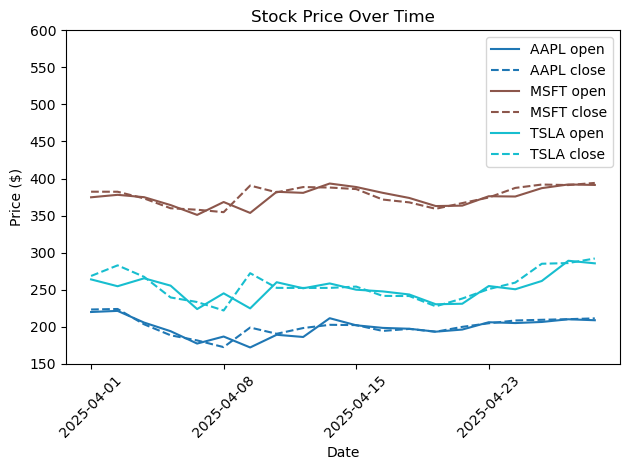

In [24]:
plot_stock_prices(df, "both", 5, 150, 600, 45)

## Distribution of returns as T + 1

<Axes: >

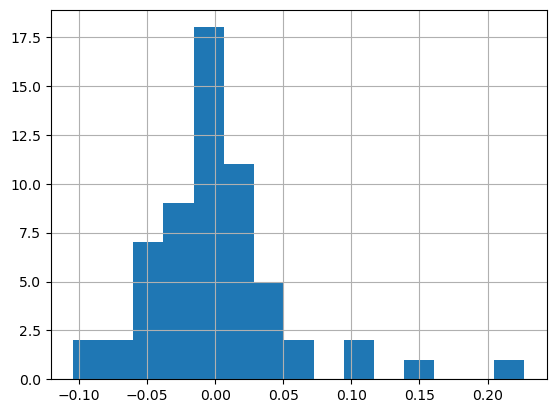

In [ ]:
df["return_t+1"].hist(bins=15)

In [32]:
df["volume"].describe()

count    6.000000e+01
mean     8.182888e+07
std      5.935890e+07
min      1.497400e+07
25%      3.445118e+07
50%      5.295280e+07
75%      1.228877e+08
max      2.194334e+08
Name: volume, dtype: float64

## Heatmap of open, close, and next day returns
- Open and close price are highly-correlated
- Open, close, and volume are not correlated with returns in T+1

<Axes: >

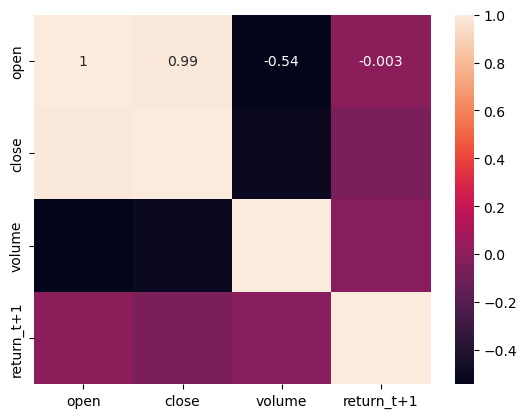

In [ ]:
# Open and close price are highly-correlated
# Open, close, and volume are not correlated with returns in T+1
sns.heatmap(df[["open", "close", "volume", "return_t+1"]].corr(), annot=True)

## Number of headlines per day by ticker

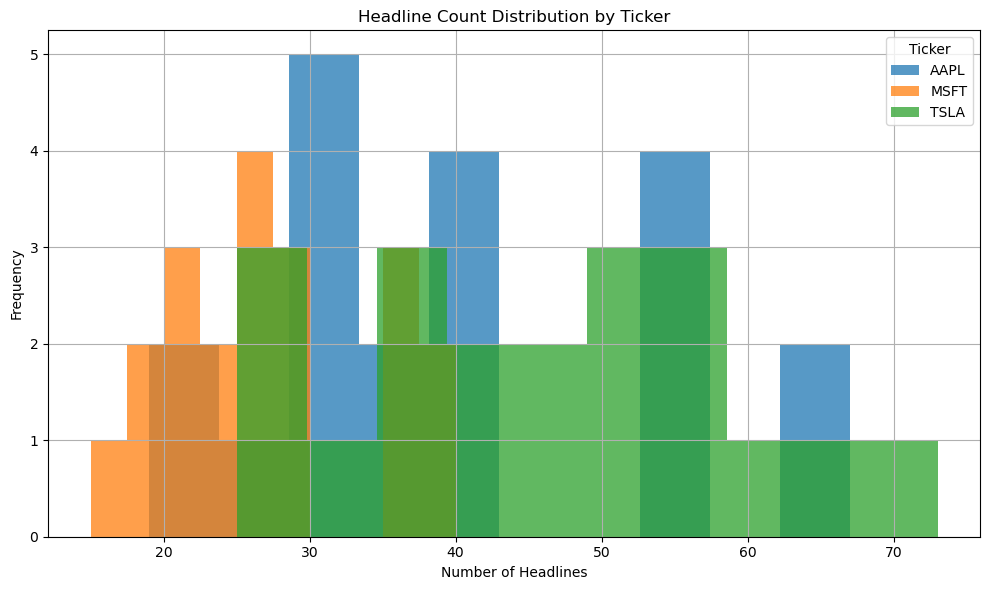

In [52]:
plt.figure(figsize=(10, 6))

for ticker, group in df.groupby("ticker"):
    group["num_headlines"].hist(alpha=0.75, label=ticker)

plt.legend(title="Ticker")
plt.xlabel("Number of Headlines")
plt.ylabel("Frequency")
plt.title("Headline Count Distribution by Ticker")
plt.tight_layout()
plt.show()


## Average returns by week (could use to calibrate across multiple stocks)

<Axes: xlabel='week'>

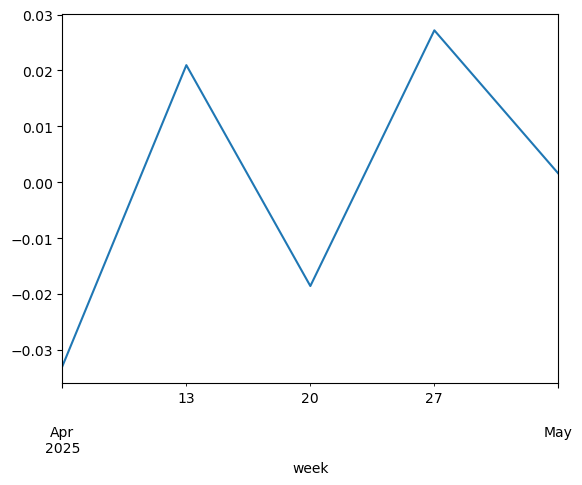

In [ ]:
df["week"] = pd.to_datetime(df["date"]).dt.to_period("W")
df.groupby("week")["return_t+1"].mean().plot()

## 2-Component PCA of BERT embeddings
- Low values for both components have lower returns
- Some structure, but not strong

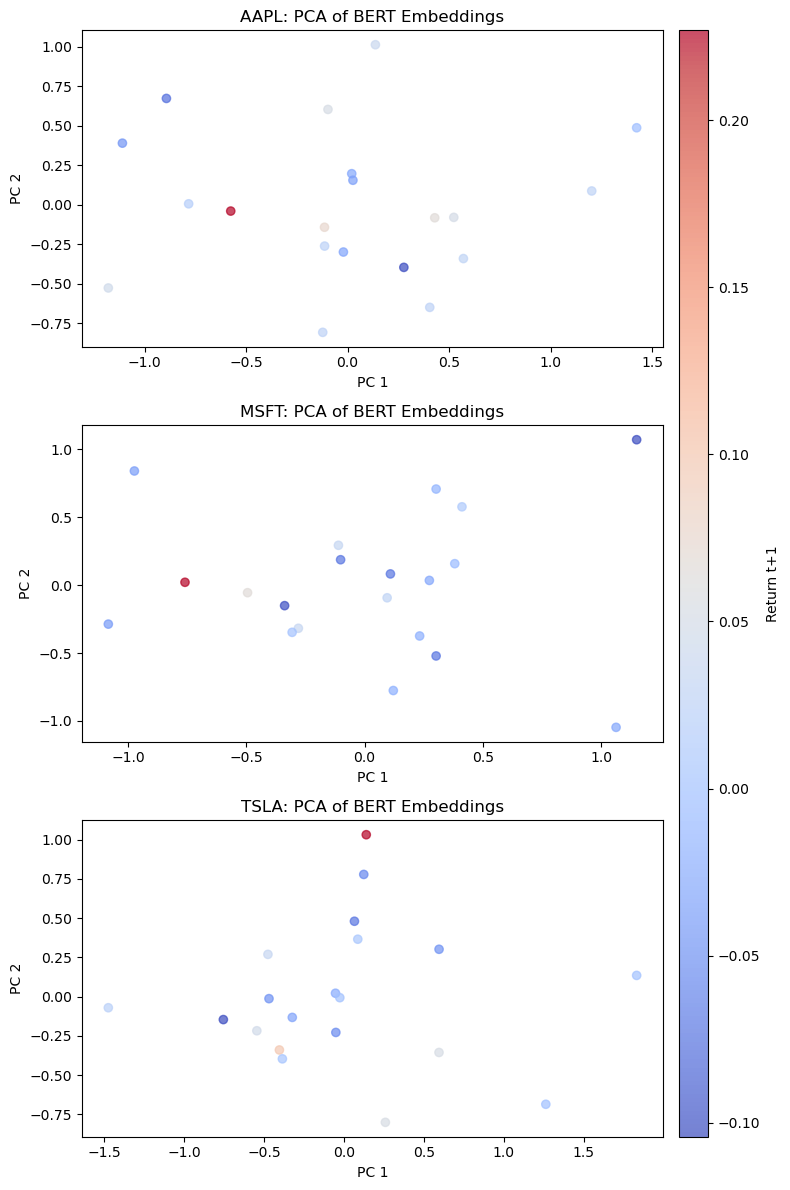

In [50]:
bert_cols = [col for col in df.columns if col.startswith("bert_")]
tickers = df["ticker"].unique()
n_tickers = len(tickers)

# Set up subplot grid with room for colorbar
fig = plt.figure(figsize=(8, 4 * n_tickers))
gs = gridspec.GridSpec(n_tickers, 2, width_ratios=[20, 1])  # last column for colorbar

scatter_refs = []

for i, ticker in enumerate(tickers):
    df_t = df[df["ticker"] == ticker]
    if len(df_t) < 10:
        continue

    X = df_t[bert_cols]
    y = df_t["return_t+1"]

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)

    ax = fig.add_subplot(gs[i, 0])
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap="coolwarm", alpha=0.7)
    ax.set_title(f"{ticker}: PCA of BERT Embeddings")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    scatter_refs.append(scatter)

# Add a single colorbar on the right
cbar_ax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(scatter_refs[-1], cax=cbar_ax)
cbar.set_label("Return t+1")

plt.tight_layout()
plt.show()


## Calculate other typical financial metrics
- Sharpe ratio
- Price momentum (3, 5, 10-day)
- Rolling volatility
- Relative strength
- Drawdown